#1. Required Libraries (in Colab)

In [ ]:
!pip install keras
!pip install ann_visualizer
!pip install graphviz

!pip install pygad>=2.10.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for ann-visualizer: filename=ann_visualizer-2.5-py3-none-any.whl size=4168 sha256=2d7f545d23dae19b168f62de2c7c25cd52e59fa1fb7e3e22e19b74e474f66390
  Stored in directory: /root/.cache/pip/wheels/1b/fc/58/2ab1c3b30350105929308becddda4fb59b1358e54f985e1f4a
Successfully built ann-visualizer
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#2. Import libraries

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow
import glob
import tensorflow.keras
import pygad.kerasga
import numpy
import pygad
import keras

from keras.models import Sequential
from keras.layers import Dense,Input
from keras.utils.vis_utils import plot_model
from ann_visualizer.visualize import ann_viz
from sklearn.model_selection import train_test_split

#3 Loading Dataset

##3-A. First Dataset


*   If you want to try next dataset, skip the following block and run the second dataset block




In [ ]:

#data = pd.read_csv('/content/drive/MyDrive/GA algorithm/GA algorithm/data.csv')


##3-B Second Dataset


*   If you want to try second dataset, run following block,(Skip pervoius one)


*   The following block include specific functions and code which are only needed for Mendeley data to prepare it for training

*    The mendley data comes from https://data.mendeley.com/datasets/j89csb932y/2. The reseach papers are cited in the link with the complete dataset. 


* We used the dataset for small and medium sized enterprises (Solvak) to determine bankruptcy. The dataset comprises of the companies that are not indexed in the stock market. The industries are small and medium sized industries. We choose to work on this dataset to develop techniques on the data that had limited statistics compared to the companies in stock market, that usually have data and analyses available on every aspect of the business.  The data comprises of three years and 21 features per year which are divided into two classes (Bankrupt and Non-Bankrupt). The annotation of the dataset considered both bankruptcy procedures and restructuring process. It spans over four industries namely Agriculture, Construction, Manufacture and Retail. Different Slovak companies in the dataset allow to understand the results better and to diminish bias created by the single nature/type of the company. 

* Input are the features in the dataset (columns) that indicate the financial features extracted from the dataset. The values were already given in the dataset, we fed it to the model and obtained results. In total we have 63 (21 per year) features. The details of the features are in the report. 



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#The path takes all the CSV files in the folder and then processes them. All the files will be added after the labels are extracted from the file names and then saved in a single dataframe. 
path = r'/content/drive/MyDrive/GA algorithm/GA algorithm/Mendeley_data' # use your path for the Mendeley Data folder containing all csv files
all_files = glob.glob(path + "/*.csv") # List of path for all csv files

data_frames = []# An empty DataFrame so we can add all csvs together

for filename in all_files:
    label=filename.split('/')[-1].split('_')[0] # extracting labels from csv file names
    
    df = pd.read_csv(filename, index_col=None, header=0, sep=';')
    df['Bankrupt?']=label
    data_frames.append(df)

data = pd.concat(data_frames, axis=0, ignore_index=True)# Concating all csv files togather

del data['Unnamed: 0'] # removing an extra index

#data=data.fillna(0.0) # filling null cells with zero

clmns=data.columns.to_list() #extracting all columns in the obtained dataframe for further processing except label column
clmns.remove('Bankrupt?')


def EroupToFloat(x):# A function to convert all numbers from Eroupean style to float numbers, e.g., 8,69 to 8.69
  if ',' in str(x):
    return float(x.replace(',','.'))
  else: return float(x)


# Applying above function to all cells in dataframe also calucalting mean of the each column and filling missing value with that mean value
for column in clmns:
  data[column]=[EroupToFloat(x) for x in data[column]]
  mean_value=data[column].mean()#calculating mean of the particular column
  
  data[column].fillna(value=mean_value, inplace=True) # filling miising cells with mean



def label2id(x): #function to covert string labels to ids
  if x=='bankrupt':return 1
  else: return 0


data['Bankrupt?']=[label2id(x) for x in data['Bankrupt?']]


##The rest of code from this point are same for both datasets

In [ ]:
data.head()#print first 5 rows of dataset

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V55,V56,V57,V58,V59,V60,V61,V62,V63,Bankrupt?
0,0.36,0.82,0.86,0.04,0.20,0.44,873.17,71.33,394.98,108.05,...,2.50,5.28,59.93,8.69,0.650000,7958.39000,0.73,12.78,43.62,0
1,12.88,47.87,10.43,0.08,1.10,1.29,294.68,217.67,212.72,39.46,...,2.71,9.30,63.12,23.95,1.150000,20843.50000,0.00,5.85,30.45,0
2,-0.61,-1.48,-0.07,0.96,0.37,0.97,38.77,-6.26,10.76,6.49,...,4.95,0.67,79.82,14.98,0.340000,19030.60399,39.18,1.34,42.14,0
3,-9.27,-46.25,-3.41,0.32,0.88,1.17,133.82,49.52,87.54,25.84,...,5.41,12.93,81.52,29.45,0.850000,19030.60399,44.11,5.85,24.28,0
4,0.03,0.36,0.02,0.22,0.65,1.14,249.10,92.67,158.68,106.92,...,59.65,26.85,98.32,0.06,23.851035,10113.00000,34.65,15.95,86.75,0


In [ ]:
data.shape #Size of Data


(51407, 64)

In [ ]:
data['Bankrupt?'].value_counts() #Label distribution in dataset---- highely imbalanced


0    51156
1      251
Name: Bankrupt?, dtype: int64

##4.Specifying the vectors and corresponding labels and train-test split

In [ ]:
y = data['Bankrupt?']
X = data.drop(columns=['Bankrupt?'])
X = np.asarray(X).astype(np.float32) # converting vectors to array forms for training in NN model
y=tf.keras.utils.to_categorical(y, num_classes=2)
class_weight = {0: 1., 1: 30.}

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)


#5. model Construction

In [ ]:
NoEpochs= 150 # you can set any number of epochs for training your NN model

In [ ]:
#The code for sequential model is taken from the KERAS library in the reference section (https://keras.io/guides/sequential_model/)
def Build_Model():
  # fix random seed for reproducibility
  np.random.seed(7)
  # create model
  model = Sequential()
  model.add(Dense(12, input_dim=X_train.shape[1], activation='relu'))
  model.add(Dense(8, activation='relu'))
  model.add(Dense(2, activation='softmax'))
  # Compile model
  model.compile(loss="categorical_crossentropy", optimizer= "adam", metrics=['accuracy'])
  # Fit the model
  model.fit(X_train, y_train, epochs=NoEpochs,class_weight=class_weight, batch_size=10)
  return model



In [ ]:
model=Build_Model()

Epoch 1/150
3599/3599 [==============================] - 10s 2ms/step - loss: 2064.6572 - accuracy: 0.9566
Epoch 2/150
3599/3599 [==============================] - 8s 2ms/step - loss: 23.1019 - accuracy: 0.9896
Epoch 3/150
3599/3599 [==============================] - 8s 2ms/step - loss: 9.5796 - accuracy: 0.9914
Epoch 4/150
3599/3599 [==============================] - 8s 2ms/step - loss: 9.6284 - accuracy: 0.9927
Epoch 5/150
3599/3599 [==============================] - 8s 2ms/step - loss: 3.5464 - accuracy: 0.9931
Epoch 6/150
3599/3599 [==============================] - 8s 2ms/step - loss: 31.0983 - accuracy: 0.9943
Epoch 7/150
3599/3599 [==============================] - 10s 3ms/step - loss: 8.3919 - accuracy: 0.9940
Epoch 8/150
3599/3599 [==============================] - 10s 3ms/step - loss: 3.5679 - accuracy: 0.9940
Epoch 9/150
3599/3599 [==============================] - 8s 2ms/step - loss: 2.8658 - accuracy: 0.9943
Epoch 10/150
3599/3599 [==============================] - 8s 2ms/

Evaluate the model on test set

In [ ]:

scores = model.evaluate(X_test, y_test)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

482/482 [==============================] - 1s 2ms/step - loss: 1.5448 - accuracy: 0.9953

accuracy: 99.53%


Visualizing the model and layers structures, istructure of thet helps us understand the structure of the sequential model. 

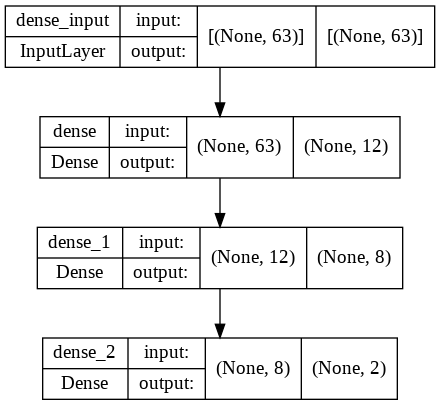

In [ ]:
#plot model shows the structure of the sequential model with the explaiantion of every layer. It is a keras feature. 
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Graphical representation of model

In [ ]:
ann_viz(model, title="Model")
#download image from network.gv.pdf

#6. Genetic Algorithm

## The code for genetic algorithm is taken from the pygad library documentation 




Assigning input data and output data

In [ ]:
#Data input
data_inputs = X_train
# Data outputs
data_outputs =y_train

## 6.1 Functions required for training NN model with GA

###Fitness Function: 
The steps used to calculate the fitness value of the model are as follows:

Restore the model parameters from the 1-D vector.

1.   Set the model parameters.
2.   Make predictions.
3.   Calculate the loss value.
4.   Calculate the fitness value.
5.   Return the fitness value.

In [ ]:
#code taken from the pygad library https://pygad.readthedocs.io/en/latest/README_pygad_ReadTheDocs.html
def fitness_func(solution, sol_idx):
    global data_inputs, data_outputs, keras_ga, model

    model_weights_matrix = pygad.kerasga.model_weights_as_matrix(model=model,
                                                                 weights_vector=solution)

    model.set_weights(weights=model_weights_matrix)

    predictions = model.predict(data_inputs)

    cce = tensorflow.keras.losses.CategoricalCrossentropy()
    solution_fitness = 1.0 / (cce(data_outputs, predictions).numpy() + 0.00000001)

    return solution_fitness

###Generation Callback Function
A callback function will be called after each generation completes to calculate some statistics about the latest parameters reached.

This function accepts a parameter referring to the instance of the genetic algorithm, by which the current population will be fetched using the population attribute.

This function prints the current generation number and the fitness value of the best solution. Such information keeps the user updated on the progress of the genetic algorithm.


In [ ]:
#code taken from the pygad library https://pygad.readthedocs.io/en/latest/README_pygad_ReadTheDocs.html
def callback_generation(ga_instance):
    print("Generation = {generation}".format(generation=ga_instance.generations_completed))
    print("Fitness    = {fitness}".format(fitness=ga_instance.best_solution()[1]))

In [ ]:
#Create an Instance of the pygad.GA Class
keras_ga = pygad.kerasga.KerasGA(model=model,num_solutions=10)#the number of solutions within the population was set to 10


###The next code block instantiates the pygad.GA class by passing the minimum number of arguments for this application

In [ ]:
NoGenerations=150 # you can set different values

In [ ]:
# Code taken from the pygad library https://pygad.readthedocs.io/en/latest/README_pygad_ReadTheDocs.html
num_generations = NoGenerations
num_parents_mating = 5 #the number of parents to mate must be less than 10 (number of solutions).
initial_population = keras_ga.population_weights

ga_instance = pygad.GA(num_generations=num_generations, 
                       num_parents_mating=num_parents_mating, 
                       initial_population=initial_population,
                       fitness_func=fitness_func,
                       on_generation=callback_generation)



##6.2 Run the Genetic Algorithm

In [ ]:
ga_instance.run()

Generation = 1
Fitness    = 12.73962409600859
Generation = 2
Fitness    = 13.759006965831263
Generation = 3
Fitness    = 13.759006965831263
Generation = 4
Fitness    = 13.759006965831263
Generation = 5
Fitness    = 13.963232985633597
Generation = 6
Fitness    = 15.927410331442438
Generation = 7
Fitness    = 17.80744256885512
Generation = 8
Fitness    = 17.80744256885512
Generation = 9
Fitness    = 17.80744256885512
Generation = 10
Fitness    = 17.80744256885512
Generation = 11
Fitness    = 17.952440320977587
Generation = 12
Fitness    = 18.556982968020396
Generation = 13
Fitness    = 18.556982968020396
Generation = 14
Fitness    = 18.556982968020396
Generation = 15
Fitness    = 18.66706670099459
Generation = 16
Fitness    = 18.66706670099459
Generation = 17
Fitness    = 19.851943755585896
Generation = 18
Fitness    = 19.851943755585896
Generation = 19
Fitness    = 19.851943755585896
Generation = 20
Fitness    = 20.277856227887316
Generation = 21
Fitness    = 20.716097502430323
Generati

#7. Results and Visualizations

/usr/local/lib/python3.7/dist-packages/pygad/pygad.py:3279: UserWarning: Please use the plot_fitness() method instead of plot_result(). The plot_result() method will be removed in the future.
  warnings.warn("Please use the plot_fitness() method instead of plot_result(). The plot_result() method will be removed in the future.")


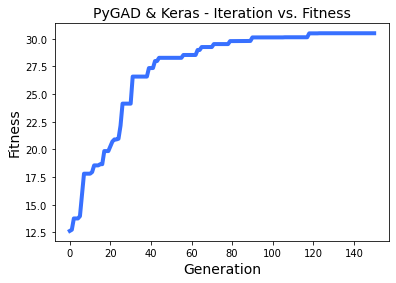

Fitness value of the best solution = 30.506384029995154
Index of the best solution : 0
Binary Crossentropy :  0.033153705
Accuracy :  0.99533165


In [ ]:
#Simple visualization code written with the help of keras library

ga_instance.plot_result(title="PyGAD & Keras - Iteration vs. Fitness", linewidth=4)#Using the plot_result() method in the pygad.GA class, PyGAD creates a figure that shows how the fitness value changes per generation.

# Returning the details of the best solution.
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))
print("Index of the best solution : {solution_idx}".format(solution_idx=solution_idx))

# Fetch the parameters of the best solution.
best_solution_weights = pygad.kerasga.model_weights_as_matrix(model=model,
                                                              weights_vector=solution)
model.set_weights(best_solution_weights)
predictions = model.predict(np.array(X_test))
# print("Predictions : \n", predictions)

# Calculate the categorical crossentropy for the trained model.
cce = tensorflow.keras.losses.CategoricalCrossentropy()
print("Binary Crossentropy : ", cce(y_test, predictions).numpy())

# Calculate the classification accuracy for the trained model.
ca = tensorflow.keras.metrics.BinaryAccuracy()

ca.update_state(y_test, predictions)
accuracy = ca.result().numpy()
print("Accuracy : ", accuracy)

# Test function to test any row in  the dataset

In [ ]:
#Test function

def Test_Function(inputRow):
  pred=model.predict(np.array(inputRow))
  pred=np.argmax(pred)
  return pred

In [ ]:
Test_Function(X_test[0:1])

0

In [ ]:
Test_Function(X_test[1:2])

0

In [ ]:
Test_Function(X_test[10:11])

0

Since the dataset is very highely imbalanced we are finding index of all samples that are predicted as 1 and then testing the model for those samples

In [ ]:
for index in range(len(X_test)):
  if Test_Function(X_test[index:index+1])==1:
    print(index)

In [ ]:
Test_Function(X_test[1154:1155])

0

In [ ]:
Test_Function(X_test[10464:10465])

0

In [ ]:
Test_Function(X_test[11109:11110])

0

# References


*   https://pygad.readthedocs.io/en/latest/
*   https://keras.io/api/models/sequential/
*   https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5603862/
*   https://scialert.net/fulltext/?doi=jas.2006.775.778
*   https://blog.paperspace.com/train-keras-models-using-genetic-algorithm-with-pygad/
*   https://www.youtube.com/watch?v=QQKYrmF4QUY 
